In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

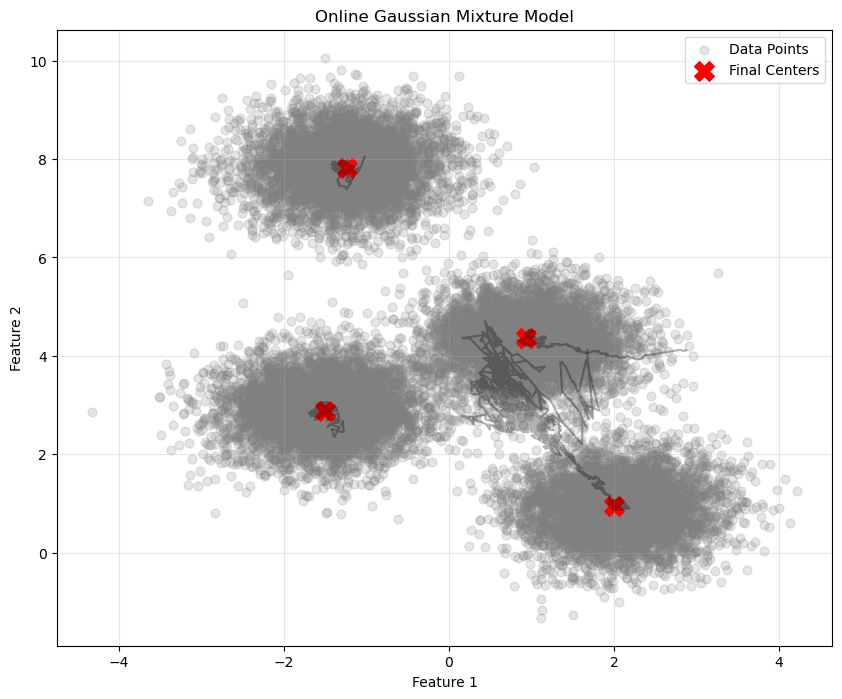

In [75]:
def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize mixing coefficients
    pi = np.ones(n_components) / n_components
    
    # Initialize means with more spread
    if first_points is not None:
        # Use the first few points with larger noise
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    # Initialize with larger covariances
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibility(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    
    # Calculate distances to each center
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    
    for k in range(n_components):
        try:
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
        except np.linalg.LinAlgError:
            sigma_k[k] = np.eye(len(x_i)) * np.trace(sigma_k[k]) / len(x_i)
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    
    # Add small constant for numerical stability
    probs += 1e-10
    
    # Sharpen the responsibilities based on distances
    gamma = probs / probs.sum()
    
    # Make responsibilities more extreme
    closest_center = np.argmin(distances)
    # gamma = gamma ** 2  # Square to make differences more extreme
    gamma = gamma / gamma.sum()  # Renormalize
    
    # If point is very close to a center, assign it mostly to that center
    min_dist = np.min(distances)
    if min_dist < 1.0:  # Threshold distance
        gamma *= 0.1  # Reduce all responsibilities
        gamma[closest_center] = 0.9  # Give high responsibility to closest center
    
    return gamma

def update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t):
    n_components = len(pi)
    n_features = len(x_i)
    min_covar = 1e-6
    
    # Update counts with momentum
    N_k = (1 - step_size) * N_k + step_size * gamma
    
    # Update mixing coefficients
    pi = N_k / N_k.sum()
    
    # Compute adaptive rates for each component based on counts in each cluster
    # adaptive_rates = np.clip(1.0 / (N_k + 1e-10), 0, 1)
    
    # Update means with adaptive rates
    for k in range(n_components):
        delta = x_i - mu_k[k]
        # effective_rate = step_size * adaptive_rates[k]
        effective_rate = step_size
        
        # More aggressive update for components with high responsibility
        # if gamma[k] > 0.5:  # If component has high responsibility
        #     effective_rate *= 2.0
        
        mu_k[k] += effective_rate * gamma[k] * delta
    
    # Update covariances
    for k in range(n_components):
        delta = x_i - mu_k[k]
        delta_out = np.outer(delta, delta)
        # effective_rate = step_size * adaptive_rates[k]
        effective_rate = step_size
        
        sigma_k[k] = (1 - effective_rate) * sigma_k[k] + \
                     effective_rate * gamma[k] * delta_out
        
        # Ensure positive definiteness
        sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2
        eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
        eigvals = np.maximum(eigvals, min_covar)
        sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return pi, mu_k, sigma_k, N_k

def online_gmm(data_generator, n_components, n_features, n_iterations, alpha=0.6, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Collect first few points for initialization
    first_points = np.array([next(data_generator) for _ in range(n_components)])
    # first_points = None  # Disable initialization with first points

    # Initialize parameters
    pi, mu_k, sigma_k = initialize_parameters(n_components, n_features, first_points, random_state)
    N_k = np.ones(n_components) / n_components
    
    # Store history for visualization
    history_mu = []
    
    # Process data points one at a time
    for t in range(n_iterations):
        x_i = next(data_generator)
        
        # Adaptive step size with slower decay
        step_size = (t + 2) ** -alpha
        
        # E-step: Compute responsibilities
        gamma = compute_responsibility(x_i, pi, mu_k, sigma_k)
        
        # M-step: Update parameters
        pi, mu_k, sigma_k, N_k = update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t)
        
        # Store current means
        history_mu.append(mu_k.copy())
        
        # Prevent centers from collapsing or getting stuck
        # if t % 50 == 0:  # Check more frequently
        #     distances = np.sqrt(((mu_k[:, None] - mu_k[None, :]) ** 2).sum(axis=2))
        #     np.fill_diagonal(distances, np.inf)
            
        #     # If centers are too close or one is near the mean
        #     if (distances < 0.5).any():
        #         # Add larger random perturbation to centers
        #         mu_k += np.random.randn(*mu_k.shape) * 0.5
    
    return pi, mu_k, sigma_k, history_mu

# Example usage remains the same as before


def data_generator(X):
    n_samples = len(X)
    while True:
        idx = np.random.randint(0, n_samples)
        yield X[idx]

if __name__ == "__main__":
    # Generate synthetic data with more separated clusters
    n_samples = 20000
    n_components = 4
    n_features = 2
    X, y_true = make_blobs(n_samples=n_samples, centers=n_components, 
                          cluster_std=0.60, random_state=0)
    
    # Create data generator
    gen = data_generator(X)
    
    # Run online GMM
    n_iterations = 20000
    alpha = 0.51
    random_state = 42
    
    pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features, 
                                              n_iterations, alpha, random_state)
    
    # Plot results
    plt.figure(figsize=(10, 8))
    
    # Plot data points
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, alpha=0.2, label='Data Points')
    
    # Plot final cluster centers
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=200, marker='X', label='Final Centers')
    
    # Plot center trajectories
    history_mu = np.array(history_mu)
    for k in range(n_components):
        plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)
    
    plt.title('Online Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
